In [37]:
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
commits = pd.read_pickle("../commits.pkl")

# Related Work

Zhou's work 

Story:
    
We find that the top 60 committers are responsible for over 80% of total commits. The similar 80/20 distribution is also discovered in Zhou's Work. We therefore focus on the busiest developers in the community.

In [143]:
result = {}
for year in range(2007, 2017):
    selected = commits[commits.committed_datetime.map(lambda t: t.year == year)]
    result[year] = selected.committer_name.value_counts(normalize=True)[:60].sum()

In [144]:
pct = pd.Series(result)
pct

2007    0.990054
2008    0.941359
2009    0.903587
2010    0.864430
2011    0.825283
2012    0.799320
2013    0.819162
2014    0.820174
2015    0.821237
2016    0.802292
dtype: float64

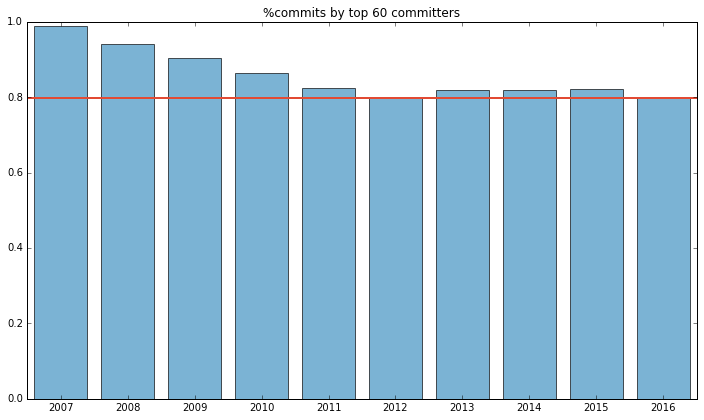

In [146]:
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(pct.index, pct, color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
plt.ylim([0,1])
plt.xlim([2006.5,2016.5])
plt.xticks(pct.index, map(lambda t: str(t), range(2007,2017)))
plt.plot(range(2006, 2018), [0.798] * (len(pct) + 2) , lw=2, color="#E24A33")
plt.title("%commits by top 60 committers")

The committer field reveals important information about the workload of linux maintainers. ...

However, simply using committers to measure the workload of linux kernel maintainers could be problematic. First of all, some linux kernel maintainers do not use git to manage their incoming patches, and therefore never show up as a committer in the linux kernel version control history. One important example of this is Andrew Morton, he is arguably one the most important maintainers in the community. However, he uses quilt to manage the patches and his name never appears in the committer field. Secondly, some patches go through multiple maintainers before landing on the kernel repository. Focusing on the committer field would underestimate the workload of other maintainers in the delivery path.

Linux kernel community uses the sign-off tag in the commit message to track the related maintainers of patches. When ..., the maintainers will add a sign-off tag as ... The sign-off tag is a better indicator of the workload of maintainers for two reasons: 1. It is added no matter whether the maintainer uses git or not and 2. Each maintainer in the delivery path has his or her name on it.

One important drawback of using sign-off tag is that unlike committer field, the sign-off tag does not have a timestamp attached on it. We use this strategy: We use the top 60 signers when timestamp information is not needed and top 60 committers when timestamp needed.

Checked: The top 60 signers are all maintainers listed on MAINTAINERS file.

In [31]:

pattern = re.compile("Signed-off-by: (.*) <.*>")
review_pattern = re.compile("Reviewed-by: (.*) <.*>")

# throughput (#commits) of top maintainers

In [147]:
result = {}
for year in range(2007, 2017):
    selected = commits[commits.committed_datetime.map(lambda t: t.year == year)]
    counter = Counter()
    for msg in selected.message:
        signers = pattern.findall(msg)
        if len(signers) > 1:
            for signer in signers[1:]:
                counter[signer] += 1
    result[year] = pd.Series(map(lambda t: t[1], counter.most_common(60)))

In [148]:
stat = pd.DataFrame(result).describe()
stat

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,502.233333,741.383333,664.066667,584.616667,616.833333,682.516667,799.183333,877.216667,867.083333,866.933333
std,1089.076259,1255.442742,1039.921067,876.988783,924.484853,1014.215109,1220.884446,1506.057870,1430.106329,1309.839360
min,52.000000,103.000000,115.000000,145.000000,177.000000,182.000000,208.000000,231.000000,228.000000,214.000000
25%,81.500000,158.500000,176.000000,195.750000,240.000000,248.500000,264.000000,317.250000,286.250000,318.000000
50%,150.000000,231.000000,285.500000,276.000000,331.500000,335.000000,391.000000,437.500000,426.500000,442.000000
75%,400.000000,642.750000,496.500000,464.500000,464.500000,529.000000,734.250000,629.750000,735.000000,820.250000
max,6015.000000,5408.000000,4861.000000,4579.000000,5734.000000,6465.000000,7706.000000,10185.000000,9585.000000,7574.000000


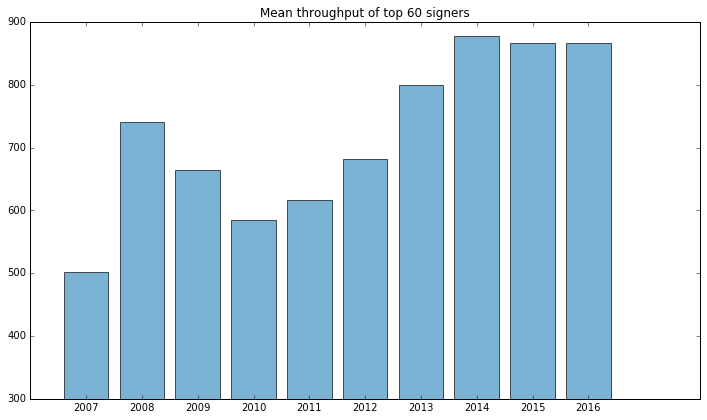

In [151]:
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
plt.ylim([300,900])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean throughput of top 60 signers")

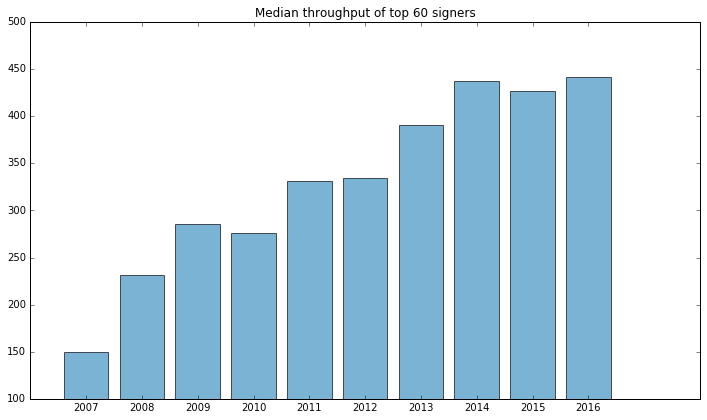

In [153]:
plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
plt.ylim([100,500])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median throughput of top 60 signers")


# Pressure (percentage of overwork commits) of top maintainers

In [154]:
result = {}
for year in range(2007, 2017):
    subset = commits[commits.committed_datetime.map(lambda t: t.year) == year]
    committers = subset.committer_name.value_counts()[:60]
    arr = []
    for committer in committers.index:
        df = subset[subset.committer_name == committer]
        s = df.committed_datetime.map(lambda t: t.hour).value_counts(normalize=True)
        if len(s) > 8:
            arr.append(s[8:].sum())
        else:
            arr.append(0.0)
    result[year] = arr

In [155]:
stat = pd.DataFrame(result).describe()

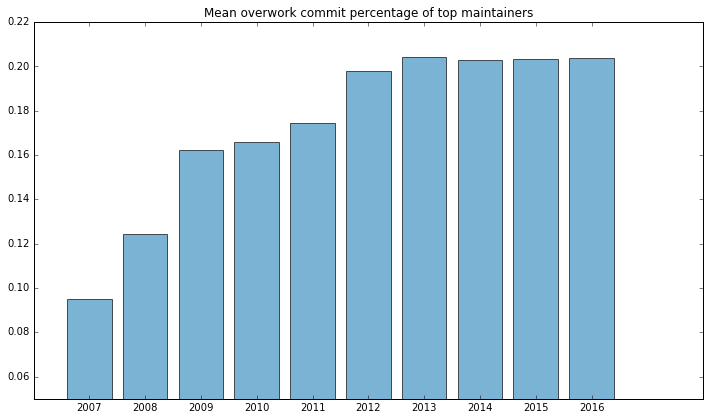

In [163]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'], color="#348ABD", alpha=0.65,
        label="Mean overwork commit percentage of top maintainers", align="center")
plt.ylim([0.05,0.22])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean overwork commit percentage of top maintainers")

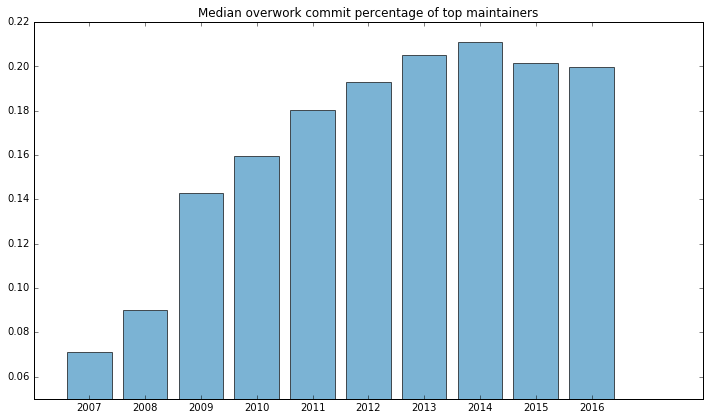

In [162]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'], color="#348ABD", alpha=0.65,
        label="Median overwork commit percentage of top maintainers", align="center")
plt.ylim([0.05,0.22])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median overwork commit percentage of top maintainers")

In [160]:
# contiguous version

In [164]:
def overwork_ratio(s):
    temp = {}
    for i in range(24):
        if i in s:
            temp[i] = s[i]
        else:
            temp[i] = 0
    for i in range(24, 48):
        temp[i] = temp[i-24]
    s = pd.Series(temp)
    s = s.sort_index()
    return 1 - s.rolling(window=8).sum().max()

In [216]:
result = {}
for year in range(2007, 2017):
    subset = commits[commits.committed_datetime.map(lambda t: t.year) == year]
    committers = subset.committer_name.value_counts()[:60]
    arr = []
    for committer in committers.index:
        df = subset[subset.committer_name == committer]
        s = df.committed_datetime.map(lambda t: t.hour).value_counts(normalize=True)
        arr.append(overwork_ratio(s))
    result[year] = arr

In [217]:
stat = pd.DataFrame(result).describe()

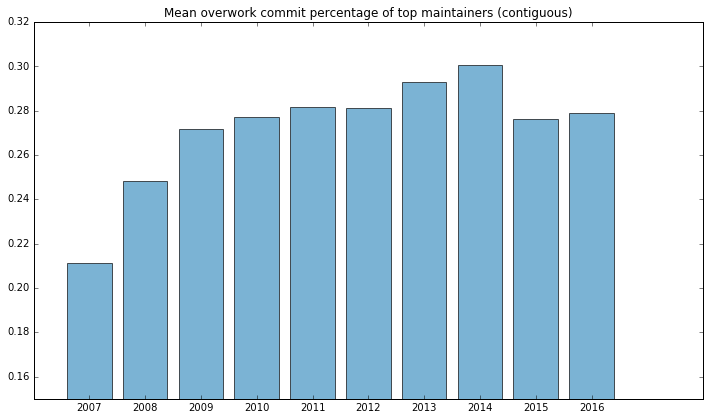

In [218]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'], color="#348ABD", alpha=0.65,
        label="Mean overwork commit percentage of top maintainers (contiguous)", align="center")
plt.ylim([0.15,0.32])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean overwork commit percentage of top maintainers (contiguous)")

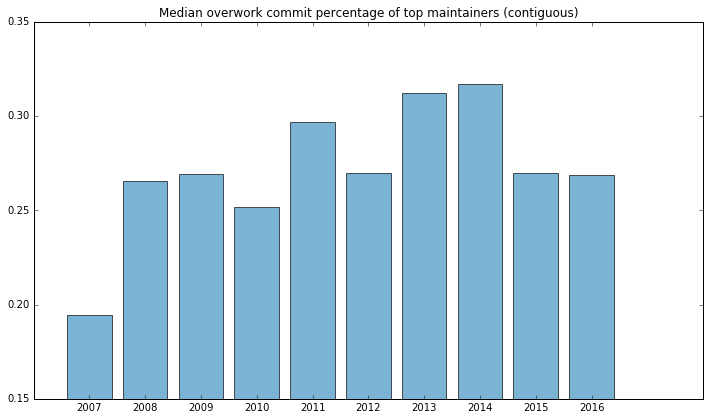

In [219]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'], color="#348ABD", alpha=0.65,
        label="Median overwork commit percentage of top maintainers (contiguous)", align="center")
plt.ylim([0.15,0.35])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median overwork commit percentage of top maintainers (contiguous)")

# Complexity (#touched files) of top maintainers

In [178]:
commits.files.map(lambda f: len(f.split(','))).quantile([0.9, 0.99,0.995, 0.999])

0.900     4.0
0.990    17.0
0.995    26.0
0.999    65.0
Name: files, dtype: float64

In [179]:
result = {}
for year in range(2007, 2017):
    selected = commits[commits.committed_datetime.map(lambda t: t.year == year)]
    counter = Counter()
    maintainer_to_file = defaultdict(lambda: set())
    for idx in selected.index:
        row = selected.loc[idx]
        msg = row['message']
        filelist = row['files'].split(',')
        if len(filelist) > 26:
            continue
        signers = pattern.findall(msg)
        if len(signers) > 1:
            for signer in signers[1:]:
                counter[signer] += 1
                for f in filelist:
                    maintainer_to_file[signer].add(f)
    result[year] = pd.Series(map(lambda t: len(maintainer_to_file[t[0]]), counter.most_common(60)))

In [180]:
stat = pd.DataFrame(result).describe()
stat

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,377.400000,450.383333,371.883333,337.200000,333.283333,366.800000,385.033333,399.150000,394.866667,419.783333
std,851.099552,820.919928,578.282791,468.462462,481.905930,503.609642,521.516757,536.563668,476.745480,492.380351
min,23.000000,31.000000,36.000000,15.000000,27.000000,25.000000,37.000000,53.000000,15.000000,60.000000
25%,70.250000,107.000000,97.000000,101.500000,87.500000,108.500000,144.750000,156.000000,151.750000,153.250000
50%,124.000000,194.000000,173.500000,190.500000,175.500000,204.500000,220.500000,248.000000,251.500000,242.500000
75%,323.250000,388.750000,333.250000,321.500000,300.500000,379.750000,349.000000,350.500000,422.500000,498.250000
max,4789.000000,4472.000000,2682.000000,2490.000000,2596.000000,2916.000000,3027.000000,3091.000000,2649.000000,2624.000000


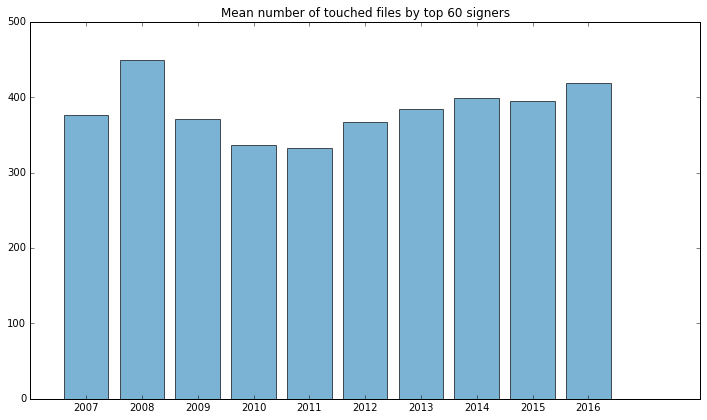

In [182]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
#plt.ylim([300,450])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean number of touched files by top 60 signers")

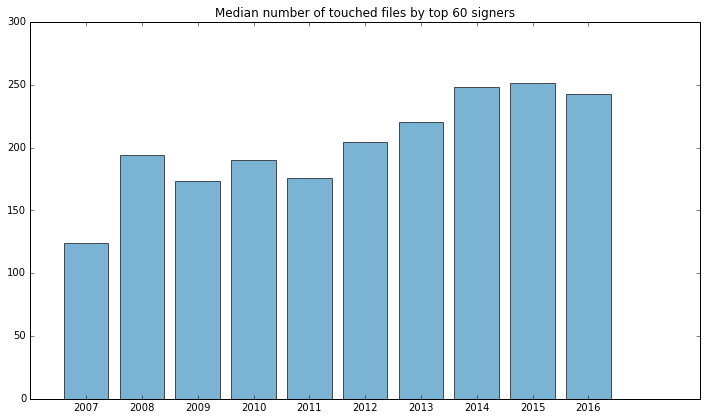

In [183]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
#plt.ylim([150,300])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median number of touched files by top 60 signers")

# Complexity (#contacts) of top maintainers

In [184]:
result = {}
for year in range(2007, 2017):
    selected = commits[commits.committed_datetime.map(lambda t: t.year == year)]
    counter = Counter()
    maintainer_to_contact = defaultdict(lambda: set())
    for idx in selected.index:
        row = selected.loc[idx]
        msg = row['message']
        signers = pattern.findall(msg)
        if len(signers) > 1:
            for i in range(1, len(signers)):
                signer = signers[i]
                prev = signers[i - 1]
                counter[signer] += 1
                maintainer_to_contact[signer].add(prev)
    result[year] = pd.Series(map(lambda t: len(maintainer_to_contact[t[0]]), counter.most_common(60)))

In [185]:
stat = pd.DataFrame(result).describe()
stat

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,60.016667,77.466667,79.700000,80.433333,78.633333,85.150000,94.766667,103.000000,107.650000,109.283333
std,92.160231,99.168316,98.704369,103.015116,98.135321,95.651703,106.452722,122.331725,127.120499,114.475827
min,6.000000,12.000000,2.000000,1.000000,2.000000,3.000000,7.000000,18.000000,2.000000,9.000000
25%,19.000000,28.250000,37.000000,36.000000,35.000000,31.750000,48.750000,48.750000,49.000000,61.000000
50%,35.500000,51.000000,46.000000,46.500000,49.500000,60.000000,65.500000,76.000000,82.500000,88.500000
75%,62.250000,71.000000,82.250000,80.500000,88.250000,106.000000,94.250000,100.250000,117.250000,108.250000
max,658.000000,635.000000,535.000000,565.000000,530.000000,505.000000,610.000000,747.000000,787.000000,669.000000


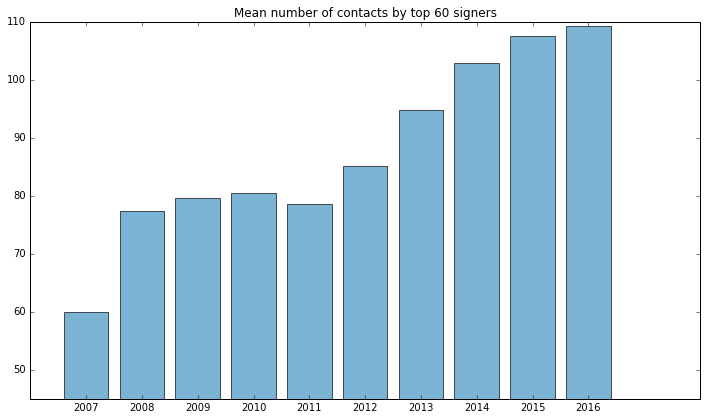

In [187]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
plt.ylim([45,110])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean number of contacts by top 60 signers")

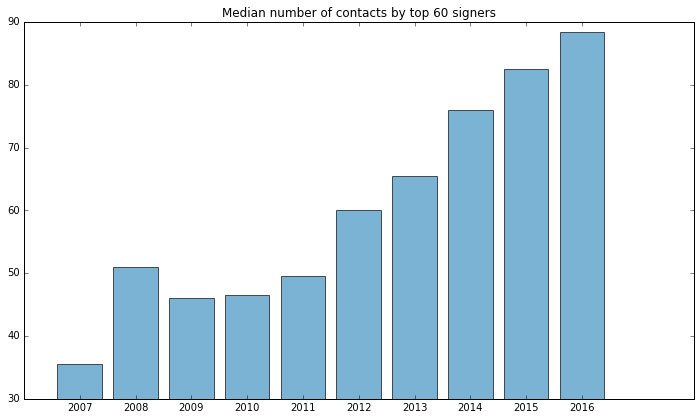

In [189]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'], color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
plt.ylim([30,90])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median number of contacts by top 60 signers")

# Latency (author to commit delay) for top maintainers

In [190]:
result = {}
for year in range(2007, 2017):
    subset = commits[commits.committed_datetime.map(lambda t: t.year) == year]
    committers = subset.committer_name.value_counts()[:60]
    arr = []
    #for committer in committers.index:
        #df = subset[subset.committer_name == committer]
        #arr.append((df.committed_datetime - df.authored_datetime).mean())
    df = subset[subset.committer_name.isin(committers.index)]
    diff = df.committed_datetime - df.authored_datetime
    quantiles = diff.quantile([0.01, 0.99])
    q_01 = quantiles.loc[0.01]
    q_99 = quantiles.loc[0.99]
    diff = diff[(diff > q_01) & (diff < q_99)]
    #result[year] = arr
    result[year] = diff.describe()

In [191]:
stat = pd.DataFrame(result)
stat

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,22917,35004,36631,35079,38000,43726,50626,53928,54910,53954
mean,13 days 19:31:44.847493,18 days 09:09:02.119129,14 days 03:53:12.427151,14 days 16:07:57.496792,14 days 07:27:09.938000,12 days 20:45:51.142729,10 days 18:02:21.009422,10 days 16:20:54.859590,10 days 21:36:36.292587,11 days 01:37:28.136727
std,21 days 03:40:17.560204,26 days 01:21:13.032907,21 days 13:44:29.920969,21 days 18:32:23.207048,24 days 03:47:54.962278,22 days 22:02:37.059875,16 days 11:54:26.625958,17 days 06:42:32.429295,16 days 01:58:02.408019,17 days 19:18:00.625550
min,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:01,0 days 00:00:02,0 days 00:00:05
25%,0 days 10:07:18,0 days 13:27:54,0 days 14:15:20,0 days 20:03:54.500000,0 days 18:14:32.750000,0 days 17:01:35.750000,0 days 18:17:52.250000,0 days 15:18:22.250000,0 days 20:37:41,0 days 19:20:44.250000
50%,2 days 18:08:09,6 days 08:04:39.500000,3 days 09:05:43,4 days 06:59:58,3 days 23:50:06.500000,3 days 19:01:34.500000,3 days 20:13:37.500000,3 days 13:41:58,4 days 03:50:25,3 days 20:02:54.500000
75%,19 days 04:23:50,26 days 05:43:28,18 days 19:44:30,19 days 02:25:49,16 days 04:03:51.500000,14 days 14:12:13.250000,13 days 15:10:41.500000,13 days 02:35:29.250000,13 days 15:29:28,13 days 06:16:29.500000
max,120 days 05:57:13,174 days 18:34:59,112 days 15:01:52,127 days 12:19:01,173 days 11:18:14,194 days 22:23:26,118 days 01:33:23,123 days 05:23:59,109 days 21:36:45,137 days 18:13:44


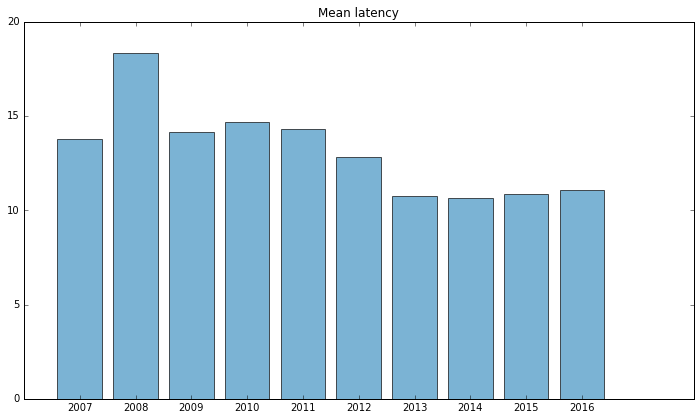

In [192]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['mean'].index, stat.loc['mean'].map(lambda t: t.delta / (86400 * 1e9)), color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
#plt.ylim([75,110])
plt.xticks(stat.loc['mean'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Mean latency")

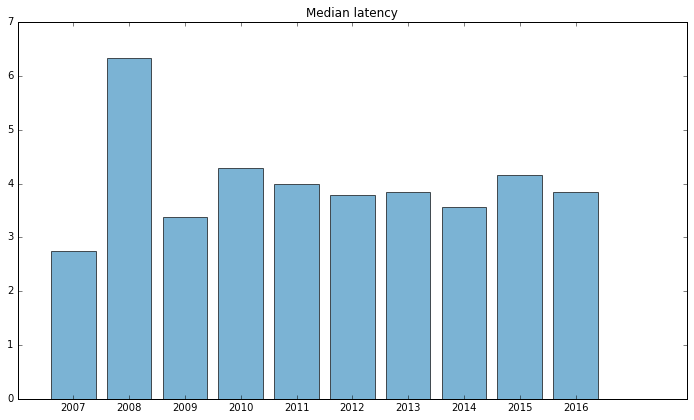

In [194]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(stat.loc['50%'].index, stat.loc['50%'].map(lambda t: t.delta / (86400 * 1e9)), color="#348ABD", alpha=0.65,
        label="Mean throughput of top 60 signers", align="center")
#plt.ylim([75,110])
plt.xticks(stat.loc['50%'].index, map(lambda t: str(t), range(2007,2017)))
plt.title("Median latency")
plt.show()

In [45]:
# ommitted, same as before

So now we can see that, from a micro perspective, the maintainers can indeed experiencing an increasing workload over the years.

Daniel Vetter also sees this, and he decides to try group committers model in intel graphics subsystem.

# i915 (intel graphics system) is an actively developed subsystem

In [102]:
# same as before, omitted

# Throughput (number/percentage of sign-offs) by the top 2 signers

Things are getting tricky after the employment of group committer model.

Before the employment of group committer model, like every other part of linux kernel, the author signs a patch and send it to the corresponding maintainer. If the maintainer decides to accept it, another sign-off tag is added and the patch is committed to maintainer's tree.

After the employment of group committer, things are getting complicated. A group of about 15 regular contributors are granted commit access to the maintainer's public tree. When a patch is submitted from a regular contributor with commit access, he/she will ask another regular contributor to review the patch. After the review process, the reivewer will add a reviewed-by tag and the author will add a sign-off tag. Now the patch has gone through all the review process, it will be committed with one reviewed-by-tag and one signed-off-tag. When a patch is from an outside contributor, it will go through the same process as that before group committer model. Considering the vast difference of the treatment regarding commits from different contributor, we use a different approach to calculate the throughput of maintainers. For insiders, we count the number of review-by tag as ... For outsiders, we count the number of sign-off tag, just like what we did in previous section.

In [195]:
def isi915(f):
    return "drivers/gpu/drm/i915/" in f or "include/drm/i915" in f or "include/uapi/drm/i915_drm.h" in f or "Documentation/gpu/i915.rst" in f

i915 = commits[commits.files.map(isi915)]

In [210]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 7:
            break
        selected = i915[i915.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        counter = Counter()
        if (year,month) < (2015,10):
            for msg in selected.message:
                signers = pattern.findall(msg)
                if len(signers) > 1:
                    for signer in signers[1:]:
                        counter[signer] += 1
        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        counter[reviewer] += 1
                else:
                    signers = pattern.findall(msg)
                    if len(signers) > 1:
                        for signer in signers[1:]:
                            counter[signer] += 1

        sorted_count = pd.Series(map(lambda t: t[1], counter.most_common()))
        log[(year,month)] = sorted_count
        result[(year, month)] = (sorted_count[:2].sum(), sorted_count[:2].sum() * 1.0 / sorted_count.sum(), sorted_count.sum())
        

In [211]:
stat = pd.DataFrame(result, index=['top2_count', 'top2_ratio', 'total']).T
stat.to_pickle('i915_throughput.pkl')

In [212]:
stat.head()

top2_count  top2_ratio  total
2013 1        93.0    0.968750   96.0
     2        43.0    0.977273   44.0
     3       101.0    0.971154  104.0
     4       124.0    0.879433  141.0
     5       121.0    0.975806  124.0

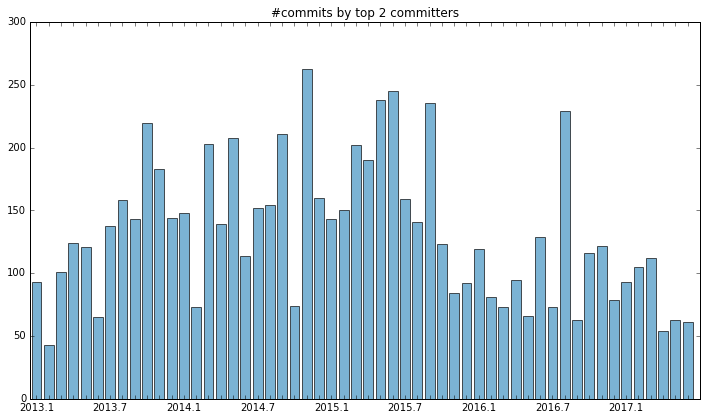

In [213]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['top2_count'])), stat['top2_count'], color="#348ABD", alpha=0.65,
            label="#commits by top 2 committers", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['top2_count'])), stat['top2_count'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['top2_count'])])
plt.title("#commits by top 2 committers")
plt.show()

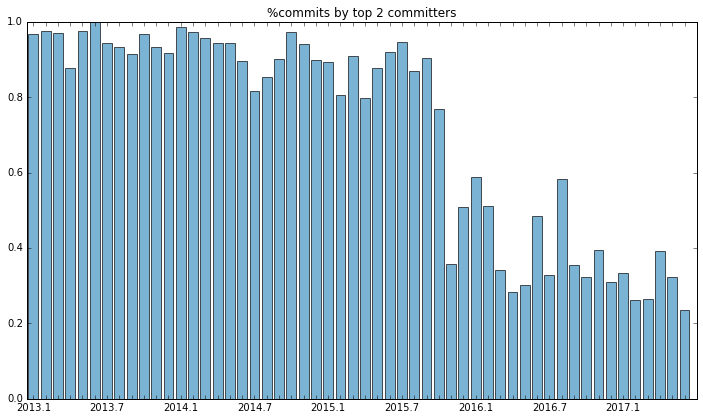

In [214]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['top2_ratio'])), stat['top2_ratio'], color="#348ABD", alpha=0.65,
            label="#commits by top 2 committers", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['top2_ratio'])), stat['top2_ratio'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['top2_ratio'])])
plt.title("%commits by top 2 committers")
plt.show()

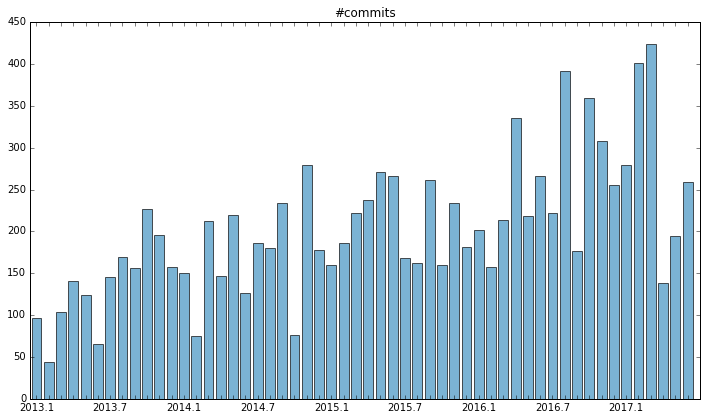

In [215]:
#stat['top2_count'].plot('bar', color='blue', figsize=(16,9)) # top 2 signers count

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(stat['total'])), stat['total'], color="#348ABD", alpha=0.65,
            label="#commits", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(stat['total'])), stat['total'].index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(stat['total'])])
plt.title("#commits")
plt.show()

# Latency comparison

In [ ]:
# Omitted, same as before

# Pressure comparison

In [118]:
# Omitted, same as before

# Complexity (file count)

In [16]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 6:
            break
        selected = i915[i915.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        dev_to_file = defaultdict(lambda: set())
        if (year,month) < (2015,10):
            for index in selected.index:
                row = selected.loc[index]
                msg = row.message
                files = row.files.split(',')
                if len(files) > 65:
                    continue
                signers = pattern.findall(msg)
                if len(signers) > 1:
                    for signer in signers[1:]:
                        for f in files:
                            dev_to_file[signer].add(f)
        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                files = row.files.split(',')
                if len(files) > 65:
                    continue
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        for f in files:
                            dev_to_file[reviewer].add(f)
                else:
                    signers = pattern.findall(msg)
                    if len(signers) > 1:
                        for signer in signers[1:]:
                            for f in files:
                                dev_to_file[signer].add(f)
        
        each_file_count = map(lambda s: len(s), dev_to_file.values())
        log[(year,month)] = dev_to_file
        result[(year, month)] = pd.Series(each_file_count).describe()
        

In [17]:
pd.DataFrame(result).T.to_pickle('i915_files.pickle')

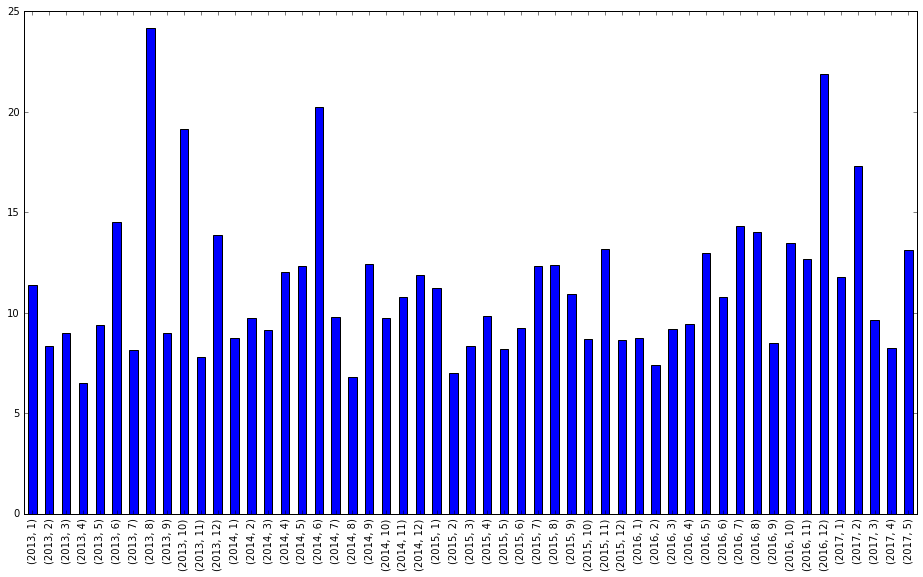

In [133]:
pd.DataFrame(result).T['mean'].plot('bar', color='blue',figsize=(16,9))

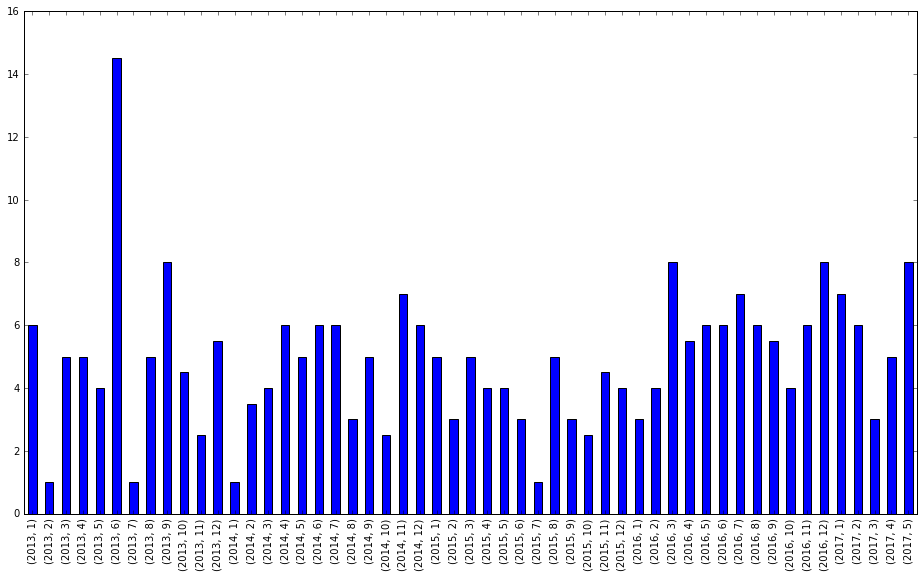

In [136]:
pd.DataFrame(result).T['50%'].plot('bar', color='blue',figsize=(16,9))

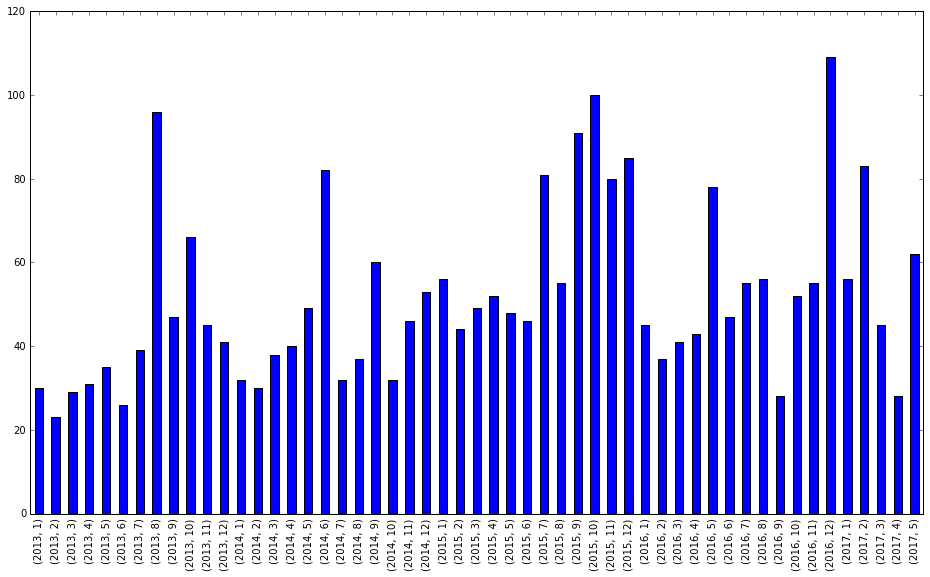

In [134]:
pd.DataFrame(result).T['max'].plot('bar', color='blue',figsize=(16,9))

# Complexity (author count)

In [13]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 6:
            break
        selected = i915[i915.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        dev_to_prev = defaultdict(lambda: set())
        if (year,month) < (2015,10):
            for index in selected.index:
                row = selected.loc[index]
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                signers = pattern.findall(msg)
                for i in range(1, len(signers)):
                    dev_to_prev[signers[i]].add(signers[i-1])

        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                files = row.files
                if len(files) > 65:
                    continue
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        dev_to_prev[reviewer].add(author)
                else:
                    signers = pattern.findall(msg)
                    for i in range(1, len(signers)):
                        dev_to_prev[signers[i]].add(signers[i-1])
        
        counts = map(lambda s: len(s), dev_to_prev.values())
        log[(year,month)] = dev_to_prev
        result[(year, month)] = pd.Series(counts).describe()
        

In [15]:
pd.DataFrame(result).T.to_pickle('i915_author.pickle')

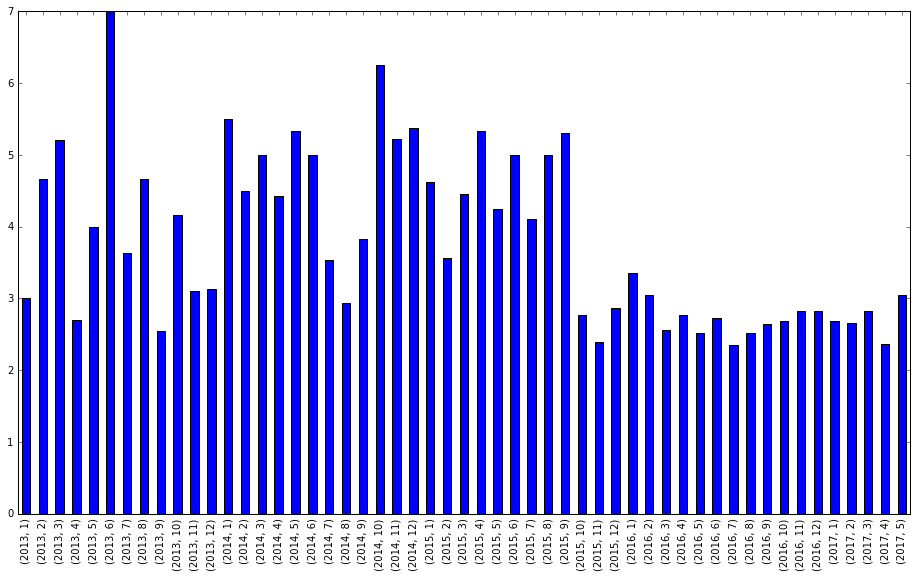

In [174]:
pd.DataFrame(result).T['mean'].plot('bar', color='blue',figsize=(16,9))

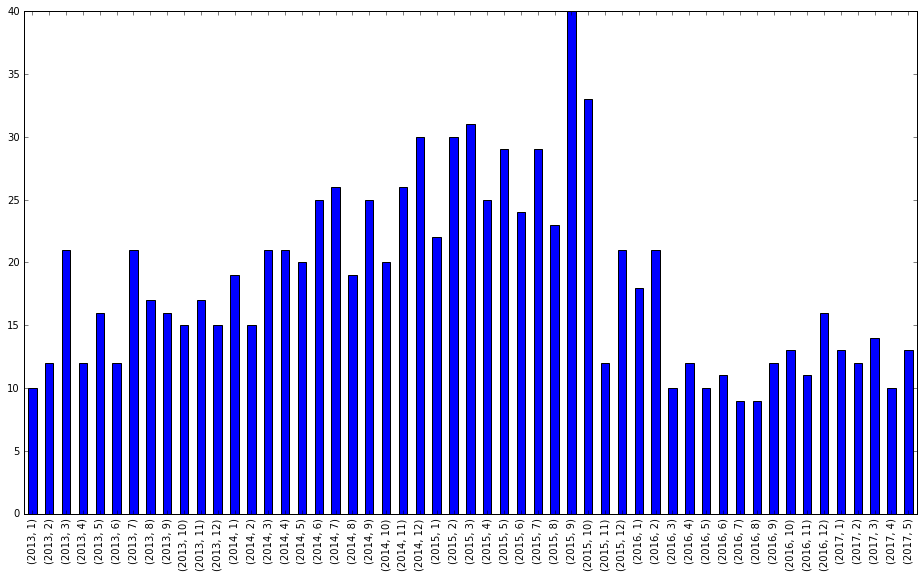

In [139]:
pd.DataFrame(result).T['max'].plot('bar', color='blue',figsize=(16,9))

# Truck factor

In [18]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 6:
            break
        selected = i915[i915.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        result[(year, month)] = selected.committed_datetime.map(lambda t: t.day).value_counts().describe()

In [20]:
pd.DataFrame(result).T.to_pickle('i915_active_day.pickle')

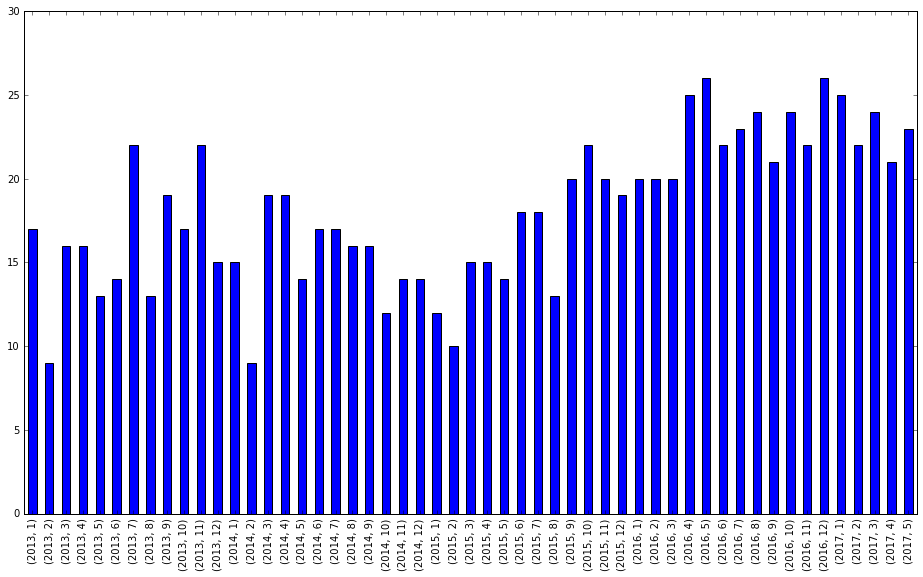

In [150]:
pd.DataFrame(result).T['count'].plot('bar', color='blue', figsize=(16,9)) # number of days with a commit

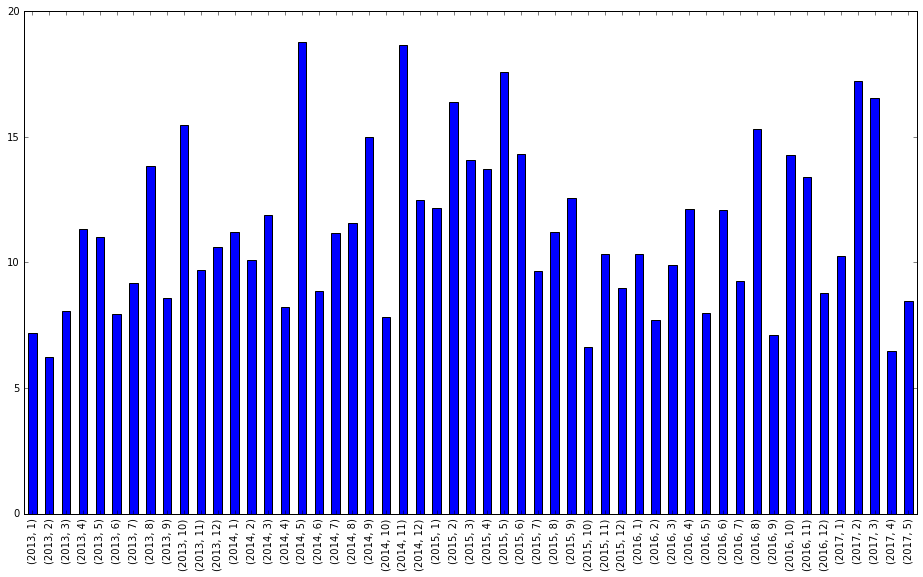

In [172]:
pd.DataFrame(result).T['mean'].plot('bar', color='blue', figsize=(16,9)) # number of commits per day

For intel graphics:

+ Lower throughput for individuals, higher throughput overall
+ Lower latency
+ Lower pressure
+ Lower complexity
+ More active days

AMD graphics subsystem is similar system compared to intel graphics subsystem. We try to compare these two subsystems in the same period to better understand the effects of group committer model.


In [176]:
# throughput

In [177]:
# latency

In [178]:
# pressure

In [179]:
# complexity

# Finally

Why it works?

In [180]:
## Company distribution

In [181]:
## Multiple devs on one file

# Visualization

Visualize the following elements:
+ Throughput (Overall / Top n) (Count / Ratio)
+ Latency (Overall / Top n)
+ Pressure (Overall / Top n)
+ Complexity (Mean / Max)